# Title I Allocations w/ DP ACS

In [1]:
from dp_policy.experiments import titlei_funding as funding, titlei_grid as test_params
from dp_policy.titlei.allocators import AbowdAllocator, SonnenbergAuthorizer
from dp_policy.titlei.utils import weighting
from dp_policy.titlei.mechanisms import Laplace, Gaussian, GroundTruth
from dp_policy.titlei.utils import *
from dp_policy.titlei.thresholders import *
from dp_policy.titlei.evaluation import *
from dp_policy.experiments import *

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns

saipe = get_inputs(2021)
sppe = get_sppe("../data/sppe18.xlsx")
print(saipe.shape)

plt.style.use('seaborn-deep')

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


/home/rsteed/dp-acs
[INFO] Successfully imputed 2937 new indices
-- WARNING: dropping some balances from total budget --
Puerto Rico 412450771.2306171
County balances 723748.7996060263
Part D Subpart 2 104168000.98352575
(13190, 25)


## Allocation Algorithm

### Data
Need state per-pupil expenditure (SPPE) from the NCES. Most recent I can find in <5min is the [FY '18 data](https://nces.ed.gov/pubsearch/pubsinfo.asp?pubid=2020308).

Had to use an online tool to convert Table 2 of [this report](https://nces.ed.gov/pubs2020/2020308.pdf).

In [3]:
sppe = get_sppe("../data/sppe18.xlsx")
sppe.head()

state    ppe abbrv
0         Alabama   9697    AL
1          Alaska  17726    AK
2  American Samoa    NaN    AS
3         Arizona   8296    AZ
4        Arkansas  10072    AR

Also need a dict matching district IDs to district names to states. Simplest to use [SAIPE 2019](https://www2.census.gov/programs-surveys/saipe/datasets/2019/2019-school-districts/) ground-truth.

Also, a method for roughly estimating standard errors for the SAIPE estimates, based on [these published docs](https://www.census.gov/programs-surveys/saipe/guidance/district-estimates.html). This could be improved - but start with this as a shortcut.

In [62]:
saipe.head()

State Postal Code                         Name  \
State FIPS Code District ID                                                  
1               1                          AL  Fort Rucker School District   
                1                          AL  Fort Rucker School District   
                1                          AL  Fort Rucker School District   
                1                          AL  Fort Rucker School District   
                1                          AL  Fort Rucker School District   

                             Estimated Total Population  \
State FIPS Code District ID                               
1               1                                  4547   
                1                                  4547   
                1                                  4547   
                1                                  4547   
                1                                  4547   

                             Estimated Population 5-17  \
State FIPS Code District ID                              
1               1                                  861   
                1                                  861   
                1                                  861   
                1                                  861   
                1                                  861   

                             Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder  \
State FIPS Code District ID                                                                                                          
1               1                                                          133                                                       
                1                                                          133                                                       
                1                                                          133                                                       
                1                                                          133                                                       
                1                                                          133                                                       

                               cv     LEAID  Sort C    State  \
State FIPS Code District ID                                    
1               1            0.42  100001.0     1.0  ALABAMA   
                1            0.42  100003.0     1.0  ALABAMA   
                1            0.42  100005.0     1.0  ALABAMA   
                1            0.42  100006.0     1.0  ALABAMA   
                1            0.42  100007.0     1.0  ALABAMA   

                             Basic Hold Harmless  ...  \
State FIPS Code District ID                       ...   
1               1                   6.145069e+04  ...   
                1                   2.085941e+04  ...   
                1                   8.205345e+05  ...   
                1                   1.319212e+06  ...   
                1                   6.089449e+05  ...   

                             Hold Harmless Percentage  Resident Pop.  \
State FIPS Code District ID                                            
1               1                            1.505202         4547.0   
                1                            0.850000         2482.0   
                1                            0.900000        22051.0   
                1                            0.901848        49087.0   
                1                            0.936605        83044.0   

                             Total Formula Count  5-17 Pop.  Percent Formula  \
State FIPS Code District ID                                                    
1               1                          135.0      861.0         0.156794   
                1                           27.0      243.0         0.111111   
                1                          971.

In [63]:
# average school district student pop
saipe["Estimated Population 5-17"].mean()
saipe["Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder"].mean()

104.63089683773975

### Code

Next, a class for the different ways we might allocate funds based on the poverty estimates (e.g. Abowd's shortcut method vs. the full Sonnenberg method).

Finally, the main method for computing estimates, then grant amounts.

-- WARNING: dropping some balances from total budget --
Puerto Rico 413911155.7939328
County balances 728460.8149536257
Part D Subpart 2 98548579.79236995
15836763981.599205


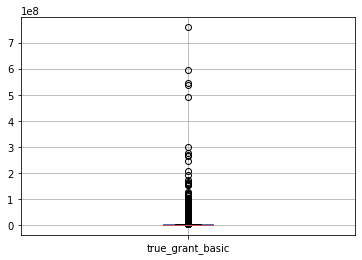

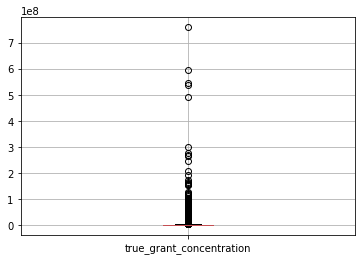

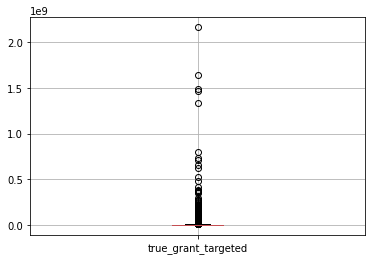

In [236]:
# Test with ground truth mechanism
saipe = get_inputs(2021)
grants = funding(SonnenbergAuthorizer, saipe, GroundTruth(), get_sppe("../data/sppe18.xlsx"))
grants.boxplot('true_grant_basic')
plt.show()
grants.boxplot('true_grant_concentration')
plt.show()
grants.boxplot('true_grant_targeted')
plt.show()

## Ground Truth Comparison
How close are our allocation estimates to the actual allocations from 2019? Note that we only have 2020's allocations, when really we need 2021's allocations, which will use the 2019 ACS data (see [here](https://www.nd.gov/dpi/sites/www/files/documents/Educational%20Equity%20%26%20Support/Title%20I/USED%20Census%202019%20Memo.pdf)). But historically the numbers are close.

/home/rsteed/dp-acs
[INFO] Successfully imputed 2937 new indices
-- WARNING: dropping some balances from total budget --
Puerto Rico 412450771.2306171
County balances 723748.7996060263
Part D Subpart 2 104168000.98352575
total
[WARN] State minimum works using 2021 data. Will be wrong for earlier years.
State level error State FIPS Code
1     6.910050e+07
2     1.727093e+07
4     8.954219e+07
5     4.526321e+07
6     5.648967e+08
8     4.836872e+07
9     4.272197e+07
10    1.698622e+07
11    1.608756e+07
12    2.209907e+08
13    1.325106e+08
15    1.554488e+07
16    1.639109e+07
17    1.592521e+08
18    6.713091e+07
19    2.982481e+07
20    2.532719e+07
21    7.428141e+07
22    8.766432e+07
23    1.761418e+07
24    8.102885e+07
25    6.772895e+07
26    1.291163e+08
27    4.826552e+07
28    5.958592e+07
29    6.625734e+07
30    1.662187e+07
31    1.805842e+07
32    3.440820e+07
33    1.513068e+07
34    9.612916e+07
35    3.381221e+07
36    2.877003e+08
37    1.281273e+08
38    1.778415e+

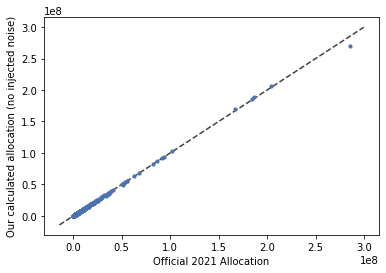

Name  \
State FIPS Code District ID                                        
6               22710        Los Angeles Unified School District   
                14550             Fresno Unified School District   
36              82047                               Kings County   
11              30           District of Columbia Public Schools   
36              82024                               Bronx County   

                             official_basic_hold_harmless  \
State FIPS Code District ID                                 
6               22710                        1.162129e+08   
                14550                        2.120322e+07   
36              82047                        8.827453e+07   
11              30                           1.774410e+07   
36              82024                        7.880462e+07   

                             official_concentration_hold_harmless  \
State FIPS Code District ID                                         
6               22710                                2.872760e+07   
                14550                                5.241393e+06   
36              82047                                2.182134e+07   
11              30                                   4.229167e+06   
36              82024                                1.931969e+07   

                             official_targeted_hold_harmless  \
State FIPS Code District ID                                    
6               22710                           1.256837e+08   
                14550                           1.861120e+07   
36              82047                           9.270965e+07   
11              30                              1.444236e+07   
36              82024                           8.123289e+07   

                             official_efig_hold_harmless  \
State FIPS Code District ID                                
6               22710                       1.381837e+08   
                14550                       1.813083e+07   
36              82047                       8.319514e+07   
11              30                          1.405369e+07   
36              82024                       7.250087e+07   

                             official_total_hold_harmless  \
State FIPS Code District ID                                 
6               22710                        4.088080e+08   
                14550                        6.318665e+07   
36              82047                        2.860007e+08   
11              30                           5.046931e+07   
36              82024                        2.518581e+08   

                             official_basic_alloc  \
State FIPS Code District ID                         
6               22710                1.199687e+08   
                14550                2.379983e+07   
36              82047                8.712931e+07   
11              30                   1.774410e+07   
36              82024                7.976208e+07   

                             official_concentration_alloc  \
State FIPS Code District ID                                 
6               22710                        3.044203e+07   
                14550                        6.039204e+06   
36              82047                        2.210905e+07   
11              30                           3.806250e+06   
36              82024                        2.023962e+07   

                             official_targeted_alloc  official_efig_alloc  \
State FIPS Code District ID                                                 
6               22710                   1.349669e+08         1.504197e+08   
                14550                   2.182530e+07         2.159909e+07   
36              82047                   9.498686e+07         8.667319e+07   
11              30                      1.371071e+07         1.360056e+07   
36              82024                   8.625801e+07         7.837469e+07   

                             ... 

basic
[WARN] State minimum works using 2021 data. Will be wrong for earlier years.
State level error State FIPS Code
1    -9.059529e+05
2     1.678302e+06
4    -1.472287e+06
5    -5.308251e+05
6     3.508586e+07
8     3.408538e+06
9    -7.503860e+05
10   -4.190583e+05
11    1.774410e+06
12   -3.460595e+06
13   -7.554960e+06
15   -7.426065e+04
16   -2.313910e+05
17   -3.494060e+06
18   -7.804844e+05
19   -4.888946e+05
20   -2.722386e+06
21    1.586333e+06
22   -3.174516e+06
23    5.816682e+05
24    2.952928e+06
25   -1.385219e+06
26   -8.981523e+05
27   -1.496863e+06
28   -8.926895e+05
29   -1.075726e+06
30   -5.135560e+04
31   -4.618631e+05
32   -6.992949e+05
33    1.231833e+06
34   -2.190058e+06
35   -5.742125e+05
36   -5.944147e+06
37   -2.222146e+06
38    2.778443e+06
39   -5.217642e+06
40   -7.472670e+05
41    1.221915e+06
42   -3.618215e+06
44   -2.837225e+05
45   -2.155308e+06
46    1.733936e+06
47   -1.062262e+06
48   -6.219283e+06
49   -4.632268e+05
50    1.686977e+06
51   -2.6

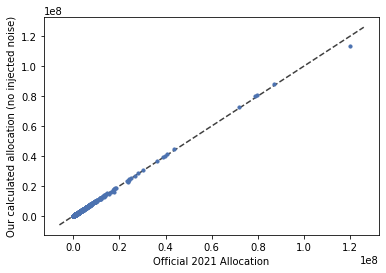

Name  \
State FIPS Code District ID                                        
6               22710        Los Angeles Unified School District   
11              30           District of Columbia Public Schools   
6               14550             Fresno Unified School District   
36              82047                               Kings County   
                82024                               Bronx County   

                             official_basic_hold_harmless  \
State FIPS Code District ID                                 
6               22710                        1.162129e+08   
11              30                           1.774410e+07   
6               14550                        2.120322e+07   
36              82047                        8.827453e+07   
                82024                        7.880462e+07   

                             official_concentration_hold_harmless  \
State FIPS Code District ID                                         
6               22710                                2.872760e+07   
11              30                                   4.229167e+06   
6               14550                                5.241393e+06   
36              82047                                2.182134e+07   
                82024                                1.931969e+07   

                             official_targeted_hold_harmless  \
State FIPS Code District ID                                    
6               22710                           1.256837e+08   
11              30                              1.444236e+07   
6               14550                           1.861120e+07   
36              82047                           9.270965e+07   
                82024                           8.123289e+07   

                             official_efig_hold_harmless  \
State FIPS Code District ID                                
6               22710                       1.381837e+08   
11              30                          1.405369e+07   
6               14550                       1.813083e+07   
36              82047                       8.319514e+07   
                82024                       7.250087e+07   

                             official_total_hold_harmless  \
State FIPS Code District ID                                 
6               22710                        4.088080e+08   
11              30                           5.046931e+07   
6               14550                        6.318665e+07   
36              82047                        2.860007e+08   
                82024                        2.518581e+08   

                             official_basic_alloc  \
State FIPS Code District ID                         
6               22710                1.199687e+08   
11              30                   1.774410e+07   
6               14550                2.379983e+07   
36              82047                8.712931e+07   
                82024                7.976208e+07   

                             official_concentration_alloc  \
State FIPS Code District ID                                 
6               22710                        3.044203e+07   
11              30                           3.806250e+06   
6               14550                        6.039204e+06   
36              82047                        2.210905e+07   
                82024                        2.023962e+07   

                             official_targeted_alloc  official_efig_alloc  \
State FIPS Code District ID                                                 
6               22710                   1.349669e+08         1.504197e+08   
11              30                      1.371071e+07         1.360056e+07   
6               14550                   2.182530e+07         2.159909e+07   
36              82047                   9.498686e+07         8.667319e+07   
                82024                   8.625801e+07         7.837469e+07   

                             ... 

concentration
[WARN] State minimum works using 2021 data. Will be wrong for earlier years.
State level error State FIPS Code
1    -1.031982e+05
2     1.532362e+05
4    -4.704991e+04
5    -6.945534e+04
6     7.416133e+06
8     5.452464e+05
9     2.561204e+03
10   -9.032346e+03
11    0.000000e+00
12    2.110367e+04
13   -1.251088e+06
15   -2.445079e+05
16   -2.725803e+05
17   -6.104095e+05
18   -1.862363e+05
19   -1.156129e+05
20   -5.663436e+05
21    3.814588e+05
22   -5.767695e+05
23   -8.112665e+04
24    8.916371e+05
25   -6.597423e+04
26   -8.934615e+04
27   -2.672891e+05
28    3.031316e+04
29   -5.160864e+05
30   -1.146889e+05
31   -5.110908e+05
32    2.459451e+04
33    5.383305e+04
34   -8.487088e+04
35    2.022562e+04
36   -2.042560e+05
37    7.716090e+04
38    2.412615e+05
39   -1.277377e+06
40   -8.497416e+03
41   -2.422003e+05
42   -3.460752e+05
44    1.288993e+03
45   -2.985014e+05
46    7.944564e+04
47   -7.947481e+05
48   -6.371342e+05
49   -3.809568e+05
50    3.741965e+04
5

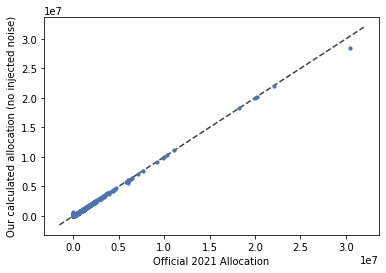

Name  \
State FIPS Code District ID                                         
6               22710         Los Angeles Unified School District   
2               180                     Anchorage School District   
31              72840                      Lincoln Public Schools   
6               14550              Fresno Unified School District   
                26370        Mount Diablo Unified School District   

                             official_basic_hold_harmless  \
State FIPS Code District ID                                 
6               22710                        1.162129e+08   
2               180                          5.860881e+06   
31              72840                        4.067561e+06   
6               14550                        2.120322e+07   
                26370                        2.568170e+06   

                             official_concentration_hold_harmless  \
State FIPS Code District ID                                         
6               22710                                2.872760e+07   
2               180                                  7.111514e+05   
31              72840                                5.409623e+05   
6               14550                                5.241393e+06   
                26370                                3.939596e+05   

                             official_targeted_hold_harmless  \
State FIPS Code District ID                                    
6               22710                           1.256837e+08   
2               180                             5.032731e+06   
31              72840                           2.665058e+06   
6               14550                           1.861120e+07   
                26370                           1.511221e+06   

                             official_efig_hold_harmless  \
State FIPS Code District ID                                
6               22710                       1.381837e+08   
2               180                         4.981777e+06   
31              72840                       3.202285e+06   
6               14550                       1.813083e+07   
                26370                       1.218204e+06   

                             official_total_hold_harmless  \
State FIPS Code District ID                                 
6               22710                        4.088080e+08   
2               180                          1.658654e+07   
31              72840                        1.047587e+07   
6               14550                        6.318665e+07   
                26370                        5.691555e+06   

                             official_basic_alloc  \
State FIPS Code District ID                         
6               22710                1.199687e+08   
2               180                  5.787300e+06   
31              72840                3.658026e+06   
6               14550                2.379983e+07   
                26370                3.140680e+06   

                             official_concentration_alloc  \
State FIPS Code District ID                                 
6               22710                        3.044203e+07   
2               180                          0.000000e+00   
31              72840                        0.000000e+00   
6               14550                        6.039204e+06   
                26370                        0.000000e+00   

                             official_targeted_alloc  official_efig_alloc  \
State FIPS Code District ID                                                 
6               22710                   1.349669e+08         1.504197e+08   
2               180                     5.104967e+06         5.093155e+06   
31              72840                   2.455668e+06         3.084438e+06   
6               14550                   2.182530e+07         2.159909e+07   
                26370                   2.023363e+06         1.644063e+06   

                           

targeted
[WARN] State minimum works using 2021 data. Will be wrong for earlier years.
State level error State FIPS Code
1    -4.787777e+05
2     1.802719e+06
4    -8.953752e+05
5    -1.690601e+05
6     2.259654e+07
8     1.590034e+06
9    -4.451385e+05
10    2.330651e+06
11    7.125924e+05
12   -3.053165e+06
13   -5.114339e+06
15   -6.039264e+04
16    2.111145e+06
17   -2.792120e+06
18   -8.515327e+05
19   -2.470060e+05
20   -1.654187e+06
21    8.905509e+05
22   -2.403236e+06
23    2.041546e+06
24    1.676828e+06
25   -1.177642e+06
26   -1.167662e+06
27   -9.432086e+05
28   -4.713010e+05
29   -1.547457e+06
30    1.818884e+06
31   -3.270169e+05
32   -6.882235e+05
33    9.804675e+05
34   -2.511082e+06
35   -3.505400e+05
36   -5.208670e+06
37   -1.601621e+06
38    2.368892e+06
39   -3.838304e+06
40   -2.892714e+05
41    5.339942e+05
42   -3.023665e+06
44    1.835316e+06
45   -1.424146e+06
46    1.755385e+06
47   -6.102017e+05
48   -6.302941e+06
49   -2.876029e+05
50    1.579062e+06
51   -

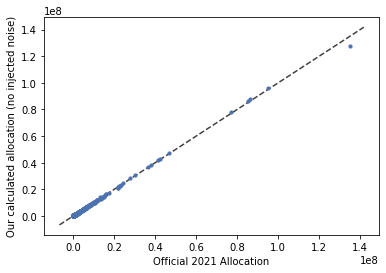

Name  \
State FIPS Code District ID                                        
6               22710        Los Angeles Unified School District   
36              82047                               Kings County   
                82024                               Bronx County   
17              9930          Chicago Public School District 299   
6               14550             Fresno Unified School District   

                             official_basic_hold_harmless  \
State FIPS Code District ID                                 
6               22710                        1.162129e+08   
36              82047                        8.827453e+07   
                82024                        7.880462e+07   
17              9930                         7.911974e+07   
6               14550                        2.120322e+07   

                             official_concentration_hold_harmless  \
State FIPS Code District ID                                         
6               22710                                2.872760e+07   
36              82047                                2.182134e+07   
                82024                                1.931969e+07   
17              9930                                 1.955829e+07   
6               14550                                5.241393e+06   

                             official_targeted_hold_harmless  \
State FIPS Code District ID                                    
6               22710                           1.256837e+08   
36              82047                           9.270965e+07   
                82024                           8.123289e+07   
17              9930                            8.232757e+07   
6               14550                           1.861120e+07   

                             official_efig_hold_harmless  \
State FIPS Code District ID                                
6               22710                       1.381837e+08   
36              82047                       8.319514e+07   
                82024                       7.250087e+07   
17              9930                        9.242648e+07   
6               14550                       1.813083e+07   

                             official_total_hold_harmless  \
State FIPS Code District ID                                 
6               22710                        4.088080e+08   
36              82047                        2.860007e+08   
                82024                        2.518581e+08   
17              9930                         2.734321e+08   
6               14550                        6.318665e+07   

                             official_basic_alloc  \
State FIPS Code District ID                         
6               22710                1.199687e+08   
36              82047                8.712931e+07   
                82024                7.976208e+07   
17              9930                 7.885334e+07   
6               14550                2.379983e+07   

                             official_concentration_alloc  \
State FIPS Code District ID                                 
6               22710                        3.044203e+07   
36              82047                        2.210905e+07   
                82024                        2.023962e+07   
17              9930                         2.000903e+07   
6               14550                        6.039204e+06   

                             official_targeted_alloc  official_efig_alloc  \
State FIPS Code District ID                                                 
6               22710                   1.349669e+08         1.504197e+08   
36              82047                   9.498686e+07         8.667319e+07   
                82024                   8.625801e+07         7.837469e+07   
17              9930                    8.518133e+07         9.596630e+07   
6               14550                   2.182530e+07         2.159909e+07   

                             ... 

In [11]:
# for validation purposes, instead of using the saipe numbers, let's use the department of education numbers
official_inputs = get_inputs(2021, use_official_children=True)

def compare_allocs(grant_type="total", **kwargs):
    allocs = funding(
        SonnenbergAuthorizer, official_inputs, GroundTruth(), sppe,
        allocator_kwargs=kwargs
    )
    print(
        "State level error",
        allocs[f"official_{grant_type}_alloc"].groupby("State FIPS Code").sum() -
        allocs[f"true_grant_{grant_type}"].groupby("State FIPS Code").sum()
    )
    if grant_type == "total":
        official = allocs[f"official_total_alloc"] - allocs[f"official_efig_alloc"]
    else:
        official = allocs[f"official_{grant_type}_alloc"]
    calculated = allocs[f"true_grant_{grant_type}"]
    allocs["error"] = official - calculated
    allocs["error_abs"] = allocs.error.abs()
    print("Average abs error", allocs.error_abs.mean())
    print(
        "RMSE", 
        np.sqrt(np.mean(np.power(allocs.error, 2))), 
        "(average alloc is", 
        np.mean(allocs[f"official_total_alloc"]), 
        ")"
    )

    ax = plt.gca()
    plt.scatter(official, calculated, s=10)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
    plt.xlabel("Official 2021 Allocation")
    plt.ylabel("Our calculated allocation (no injected noise)")
    plt.savefig(f"../plots/robustness/official_{grant_type}.png", dpi=300)
    plt.show()

    # plt.hist(allocs.error, bins=50)
    # plt.show()

    display(allocs.sort_values("error_abs", ascending=False).head(5))

for grant_type in ["total", "basic", "concentration", "targeted"]:
    print(grant_type)
    compare_allocs(grant_type=grant_type, state_minimum=True, hold_harmless=True)

## Laplace

### Results
First, using the full Sonnenberg authorization algo.

In [14]:
results = test_params(saipe, Laplace, eps=[0.01, 0.1, 1.0, 2.52, 10.0]+list(np.logspace(-3, 0.1, num=5)), trials=1000, print_results=False)
pickle.dump(results, open("../rfesults/titlei_laplace.pkl", 'wb'))

10000 iters:


trial: 100%|██████████| 1000/1000 [8:38:30<00:00, 31.11s/it] 


In [2]:
# saves memory for printing/plotting large runs
prefixes = ["est", "dp", "dpest"]
results = pickle.load(open("../results/titlei_laplace.pkl", 'rb'))
results = results.loc[pd.IndexSlice[slice(10), :, :, :, :]]
results = results[[
    c for c in results.columns
    if any(
      p in c for p in prefixes + ["true"]
    )
]]

[0.1, 1.0, 2.52, 10.0, 30, 0.001, 0.0027825594022071257, 0.007742636826811269, 0.021544346900318832, 0.05994842503189409, 0.1668100537200059, 0.46415888336127775, 1.2915496650148828, 3.593813663804626, 10.0]
--- eps=0.01 ---


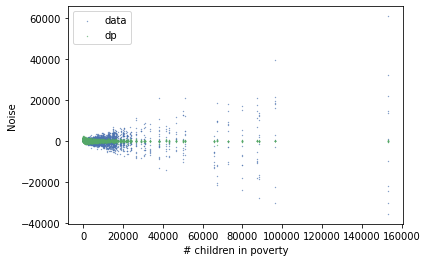

--- eps=0.1 ---


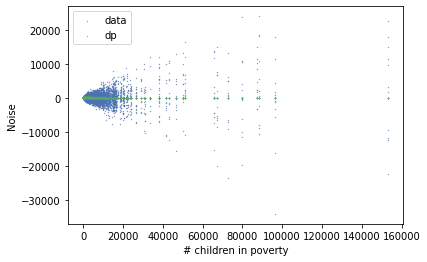

--- eps=1.0 ---


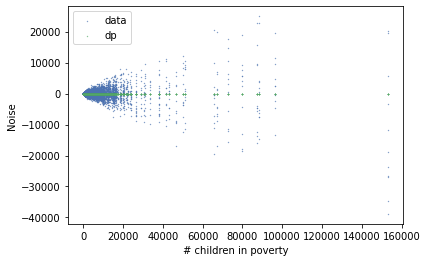

In [4]:
print([0.1, 1.0, 2.52, 10.0, 30]+list(np.logspace(-3, 1, num=10)))
# test_params(None, None, results=results, print_results=[0.01, 0.1, 1.0, 10.0, 30.0], plot_results=True)
test_params(None, None, results=results, print_results=[0.01, 0.1, 1.0, 10.0], plot_results=True)

### Sanity check: using Abowd's method

Abowd reported a mean squared SPPE of 20 million from 2014-15 data.

In [8]:
grants = funding(AbowdAllocator, saipe, Laplace(2.52, 0, sensitivity=2.0), get_sppe("../data/sppe18.xlsx"))
print("Mean Sq. SPPE (2018):", np.mean(grants.adj_sppe**2))

Mean Sq. SPPE (2018): 25804346.403312244


They also report an RMSE at e=2.52 of 2509 (again, using 2014-15 Common Core data, which I can't replicate) and 1334 at e=4.74 and 63000 at e=0.1. 

In [9]:
# RMSE
error = grants.true_grant_total - grants.dp_grant_total
np.sqrt(np.mean(error**2))

5687.452208208677

In [10]:
print("Total misalloc at eps=2.52:", sum(abs(error)))

Total misalloc at eps=2.52: 52144217.36587607


In [11]:
grants = funding(AbowdAllocator, saipe, Laplace(4.74, 0), get_sppe("../data/sppe18.xlsx"))
error = grants.true_grant_total - grants.dp_grant_total
np.sqrt(np.mean(error**2))

3022.9215913293833

In [12]:
grants = funding(AbowdAllocator, saipe, Laplace(0.1, 0), get_sppe("../data/sppe18.xlsx"))
error = grants.true_grant_total - grants.est_grant_total
np.sqrt(np.mean(error**2))

2390438.406534202

## Uncertainty

Adapted from `plot_sampling.ipynb`.

In [3]:
eps = [0.001, 0.01, 0.1, 1.0, 10]
num_trials = 100
num_bins = 10

In [4]:
laplace = test_params(saipe, Laplace, eps=[0.001, 0.01, 0.1, 1.0, 10], delta=[0.0], trials=num_trials, print_results=False, plot_results=False)
# gaussian = test_params(saipe, Gaussian, eps=[0.01, 0.1, 2.52], delta=[1e-6], trials=num_trials, print_results=False, plot_results=False)

pickle.dump(laplace, open("../results/bootstrap/laplace.pkl", 'wb'))
# pickle.dump(gaussian, open("../results/bootstrap/gaussian.pkl", 'wb'))

In [4]:
baseline = test_params(saipe, GroundTruth, eps=[0.0], delta=[0.0], trials=num_trials, print_results=False, plot_results=False)
pickle.dump(baseline, open("../results/bootstrap/baseline.pkl", 'wb'))

100 iters:


trial: 100%|██████████| 100/100 [07:06<00:00,  4.27s/it]


In [5]:
baseline = pickle.load(open("../results/bootstrap/baseline.pkl", 'rb'))
laplace = pickle.load(open("../results/bootstrap/laplace.pkl", 'rb'))
# gaussian = pickle.load(open("../results/bootstrap/gaussian.pkl", 'rb'))

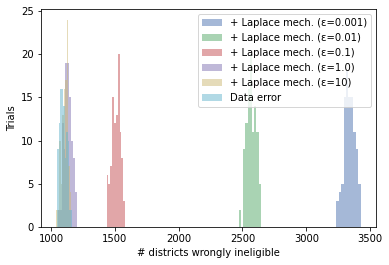

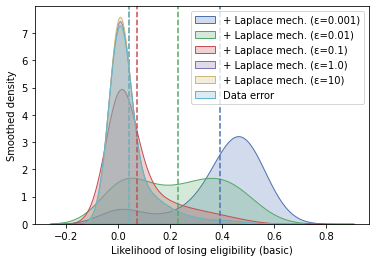

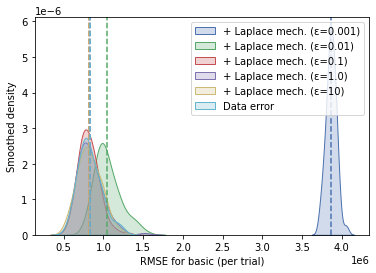

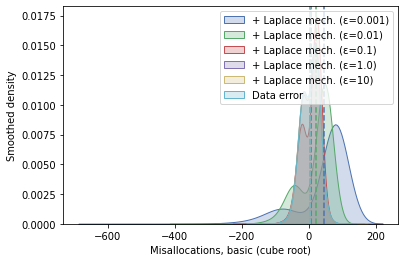

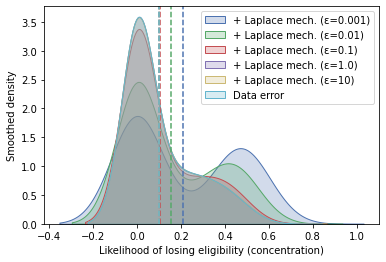

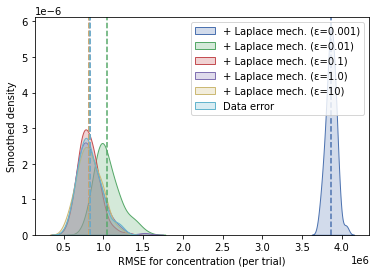

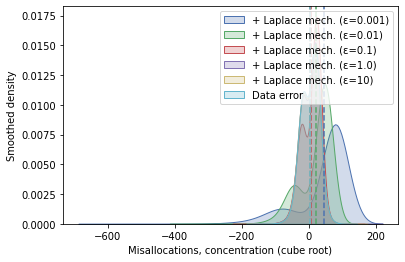

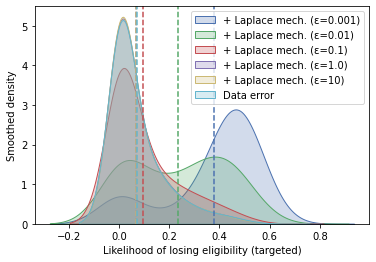

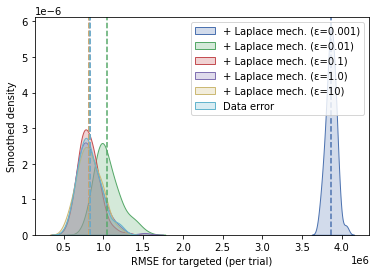

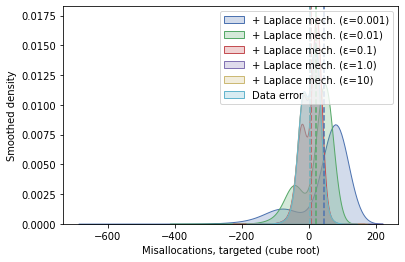

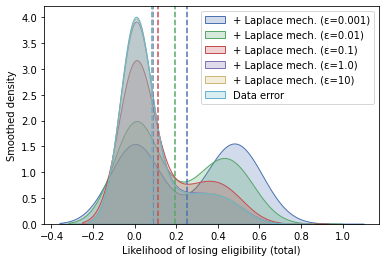

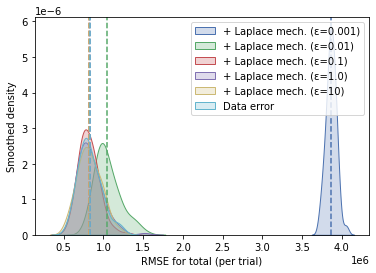

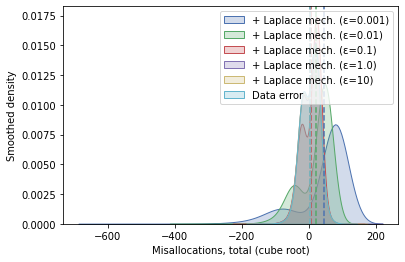

In [6]:
treatments = {
  "+ Laplace mech. (ε={})".format(e): laplace.loc[pd.IndexSlice[:, 0.0, e, :, :], :].copy()
  for e in eps
}
treatments["Data error"] = baseline

plot_treatments(
  treatments,
  lambda df: df.groupby('trial')["lost_eligibility"].sum(),
  plt.hist,
  dict(bins=num_bins, alpha=0.5),
  filename="ineligible_hist",
  xlab="# districts wrongly ineligible",
  ylab="Trials"
)

for grant in [
  "basic",
  "concentration",
  "targeted",
  "total"
]:
  plot_treatments(
    treatments,
    lambda df: df.groupby(['State FIPS Code', 'District ID'])["lost_eligibility"].mean(),
    sns.kdeplot,
    dict(bw_method=0.5, fill=True),
    filename=f"likelihood_ineligible_{grant}",
    xlab=f"Likelihood of losing eligibility ({grant})",
    grant=grant,
    mean_line=True
  )

  plot_treatments(
    treatments,
    lambda df: np.sqrt(df.groupby('trial')["misalloc_sq"].mean()),
    sns.kdeplot,
    dict(bw_method=0.5, fill=True),
    filename=f"rmse_{grant}",
    xlab=f"RMSE for {grant} (per trial)",
    mean_line=True
  )

  plot_treatments(
    treatments,
    lambda df: \
      np.sign(df.groupby(['State FIPS Code', 'District ID'])["misalloc"].mean())*np.power(
        np.abs(df.groupby(['State FIPS Code', 'District ID'])["misalloc"].mean()), 1/3),
    sns.kdeplot,
    dict(bw_method=0.5, fill=True),
    filename=f"misalloc_{grant}",
    xlab=f"Misallocations, {grant} (cube root)",
    mean_line=True
  )

## Discrimination

In [2]:
eps = 0.1

results = load_treatments("baseline")['baseline'].loc[pd.IndexSlice[:, 0.0, eps, :, :], :]
print(results.shape)

(13190000, 38)


### Summary Stats

In [3]:
grants = discrimination_join(results, save_path=f"../results/baseline_eps={eps}", verbose=True)

[INFO] Successfully imputed 1573 new indices
[INFO] Successfully imputed 1573 new indices
[INFO] Successfully imputed 1573 new indices
[INFO] Successfully imputed 1573 new indices
(13294, 257)
(13293, 341)
(13294, 203)
(13294, 495)
['Total population (RACE) - est', 'White (RACE) - pct', 'Black or African American (RACE) - pct', 'Cherokee tribal grouping (RACE) - pct', 'Chippewa tribal grouping (RACE) - pct', 'Navajo tribal grouping (RACE) - pct', 'Sioux tribal grouping (RACE) - pct', 'Asian (RACE) - pct', 'Asian Indian (RACE) - pct', 'Chinese (RACE) - pct', 'Filipino (RACE) - pct', 'Japanese (RACE) - pct', 'Korean (RACE) - pct', 'Vietnamese (RACE) - pct', 'Other Asian (RACE) - pct', 'Native Hawaiian (RACE) - pct', 'Guamanian or Chamorro (RACE) - pct', 'Samoan (RACE) - pct', 'Some other race (RACE) - pct', 'Two or more races (RACE) - pct', 'Mexican (HISPANIC OR LATINO AND RACE) - pct', 'Puerto Rican (HISPANIC OR LATINO AND RACE) - pct', 'Cuban (HISPANIC OR LATINO AND RACE) - pct', 'Othe

### Geography

13190000


/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/rsteed/dp-acs/dp_policy/titlei/evaluation.py:309: FutureWarning: ['switched_eligibility', 'became_eligible', 'became_ineligible', 'switched_eligibility_dp', 'became_eligible_dp', 'became_ineligible_dp'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  results[[
/home/rsteed/dp-acs/dp_policy/titlei/evaluation.py:308: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  joined = geo.join(


<AxesSubplot:>

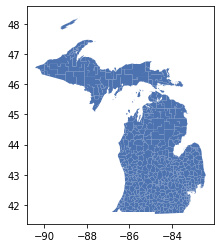

In [3]:
print(len(results))
joined = geo_join(results)
joined.loc[26].plot()

In [ ]:
## AVERAGE ERROR
dperr = cube(joined.loc[[
    f for f in joined.index.get_level_values("State FIPS Code").unique()
    if f not in [2, 15]
]]["error_dp_per_child_eligible"])
dpmin = dperr.min()
dpmax = dperr.max()
serr = cube(joined.loc[[
    f for f in joined.index.get_level_values("State FIPS Code").unique()
    if f not in [2, 15]
]]["error_per_child_eligible"])
smin = serr.min()
smax = serr.max()
ymin = smin if smin <= dpmin else dpmin
ymax = smax if smax >= dpmax else dpmax

heatmap(
    joined.loc[[
        f for f in joined.index.get_level_values("State FIPS Code").unique()
        if f not in [2, 15]
    ]],
    label="Expected misallocation per eligible child (cube root)",
    y="error_dp_per_child_eligible",
    file="misalloc_nation.png",
    figsize=(15,10),
    bar_location = 'right'
    # min=ymin,
    # max=ymax
)
heatmap(
    joined.loc[[
        f for f in joined.index.get_level_values("State FIPS Code").unique()
        if f not in [2, 15]
    ]],
    y="error_per_child_eligible",
    label="Expected misallocation per eligible child (cube root)",
    file="misalloc_nation_sampling.png",
    figsize=(15,10),
    bar_location = 'right',
    min=ymin,
    max=ymax
)
heatmap(
    joined.loc[[
        f for f in joined.index.get_level_values("State FIPS Code").unique()
        if f not in [2, 15]
    ]],
    y="dp_marginal",
    label="Expected misallocation per eligible child (cube root)",
    file="misalloc_nation_marginal.png",
    figsize=(15,10),
    bar_location = 'right'
)

In [4]:
## WORST-CASE ERROR
dperr = cube(joined.loc[[
    f for f in joined.index.get_level_values("State FIPS Code").unique()
    if f not in [2, 15]
]]["error_dp_per_child_eligible_percentile_5.0"])
dpmin = dperr.min()
dpmax = dperr.max()
serr = cube(joined.loc[[
    f for f in joined.index.get_level_values("State FIPS Code").unique()
    if f not in [2, 15]
]]["error_per_child_eligible_percentile_5.0"])
smin = serr.min()
smax = serr.max()
ymin = smin if smin <= dpmin else dpmin
ymax = smax if smax >= dpmax else dpmax

heatmap(
    joined.loc[[
        f for f in joined.index.get_level_values("State FIPS Code").unique()
        if f not in [2, 15]
    ]],
    label="5% quantile misallocation per eligible child (cube root)",
    y="error_dp_per_child_eligible_percentile_5.0",
    file="misalloc_nation_worst.png",
    figsize=(15,10),
    bar_location = 'right',
    alpha=None,
    vcenter=None,
    theme="YlOrRd"
    # min=ymin,
    # max=ymax
)
heatmap(
    joined.loc[[
        f for f in joined.index.get_level_values("State FIPS Code").unique()
        if f not in [2, 15]
    ]],
    y="error_per_child_eligible_percentile_5.0",
    label="5% quantile misallocation per eligible child (cube root)",
    file="misalloc_nation_sampling_worst.png",
    figsize=(15,10),
    bar_location = 'right',
    alpha=None,
    min=ymin,
    max=ymax,
    vcenter=None,
    theme="YlOrRd"
)
heatmap(
    joined.loc[[
        f for f in joined.index.get_level_values("State FIPS Code").unique()
        if f not in [2, 15]
    ]],
    y="dp_marginal_percentile_5.0",
    label="5% quantile misallocation per eligible child (cube root)",
    file="misalloc_nation_marginal_worst.png",
    figsize=(15,10),
    alpha=None,
    bar_location = 'right',
    vcenter=None,
    theme="YlOrRd"
)

All but 3 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 0.0


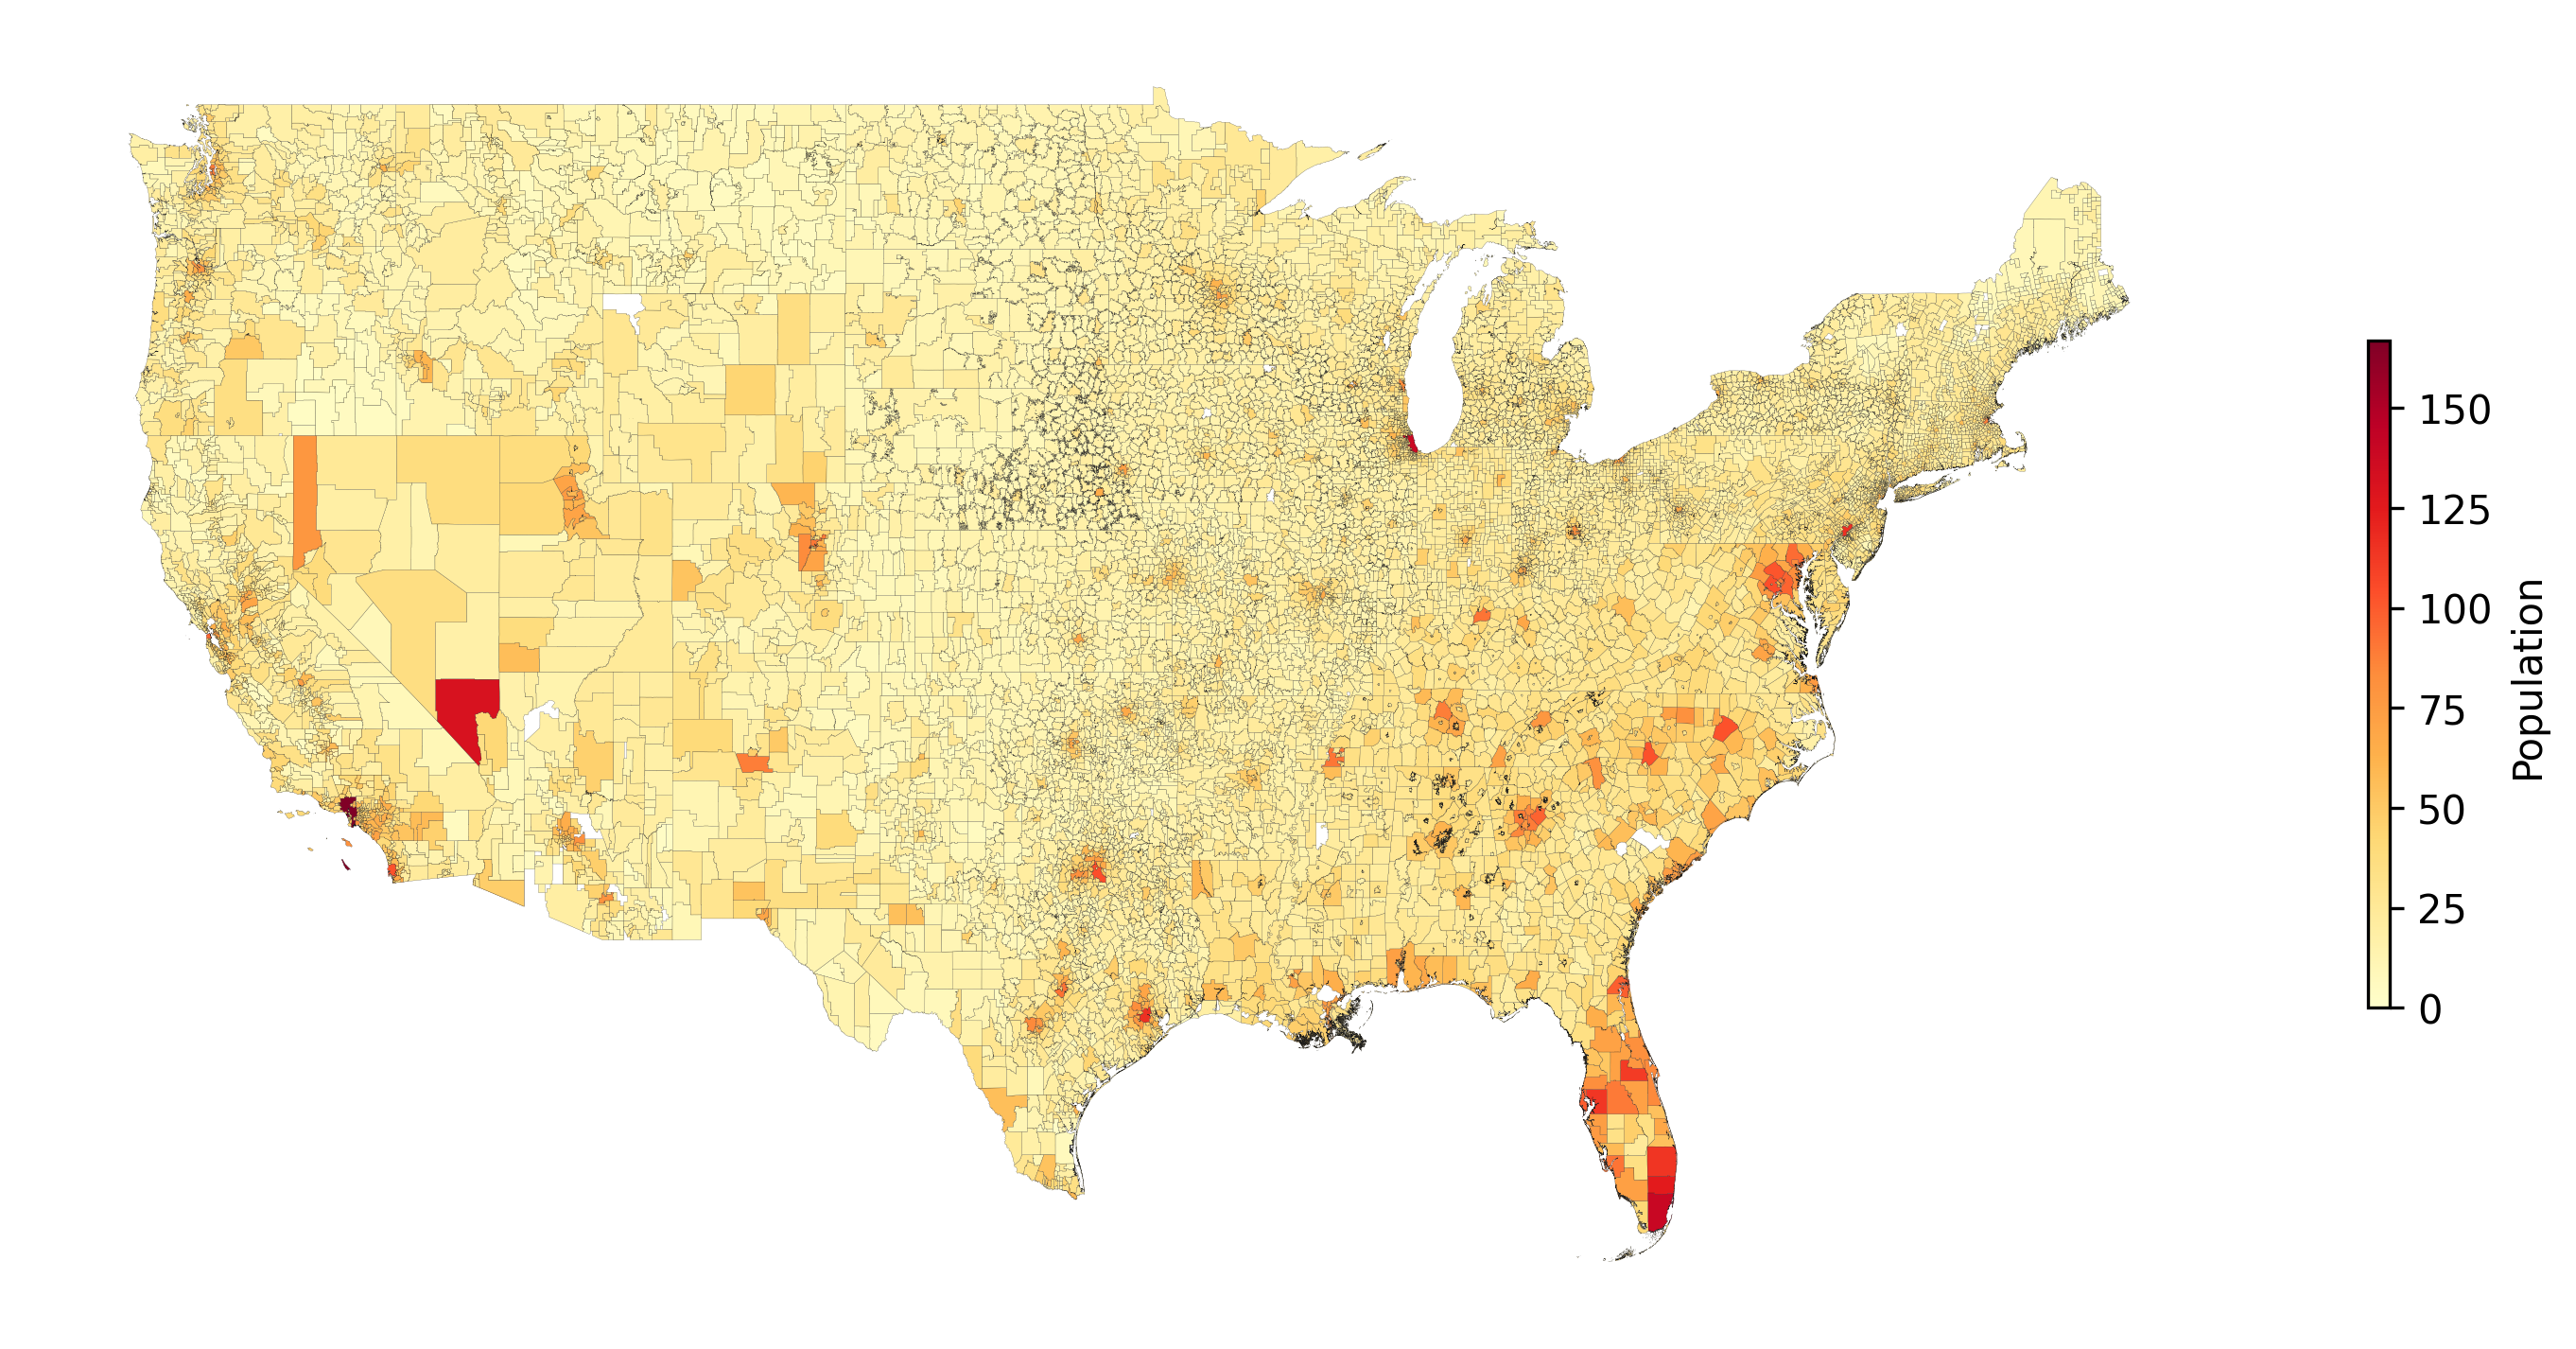

In [6]:
heatmap(
    joined.loc[[
        f for f in joined.index.get_level_values("State FIPS Code").unique()
        if f not in [2, 15]
    ]],
    "Population",
    vcenter=None,
    y="true_pop_total",
    theme="YlOrRd"
)

In [6]:
acs = get_acs_unified()
joined_acs = joined.join(acs['White (RACE) - pct'], how="left")
joined_acs["prop_nonwhite"] = 1 - pd.to_numeric(joined_acs['White (RACE) - pct'], errors='coerce') / 100
joined_acs.prop_nonwhite.describe()
for state in [
#     (26, "Michigan"),
#     (37, "North Carolina"),
    # (72, "Puerto Rico"),
    (42, "Pennsylvania")
]:
    # heatmap(joined_acs.loc[state[0]], "Prop. non-white-only", y="prop_nonwhite", transform=None, vcenter=None, theme="Blues")
    # heatmap(joined.loc[state[0]], "% switched eligibility for any grant", y="switched_eligibility", transform=None, vcenter=None, theme="Oranges")
    heatmap(
        joined.loc[state[0]], 
        "Likelihood of becoming wrongly ineligible for any grant", 
        file="ineligible.png",
        y="became_ineligible", 
        transform=None, 
        vcenter=None, 
        theme="Oranges",
        min=0
    )
    heatmap(
        joined.loc[state[0]], 
        "Likelihood of becoming wrongly ineligible for any grant", 
        file="ineligible_dp.png",
        y="became_ineligible_dp", 
        transform=None, 
        vcenter=None, 
        theme="Oranges",
        min=0
    )
    heatmap(
        joined.loc[state[0]], 
        "Likelihood of becoming wrongly eligible for any grant", 
        file="eligible.png",
        y="became_eligible", transform=None, vcenter=None, theme="Greens",
        min=0
    )
    heatmap(
        joined.loc[state[0]], 
        "Likelihood of becoming wrongly eligible for any grant", 
        file="eligible_dp.png",
        y="became_eligible_dp", transform=None, vcenter=None, theme="Greens",
        min=0
    )
    # heatmap(joined.loc[state[0]], f"Misallocation per child in {state[1]} (cube root)")
    # heatmap(joined.loc[state[0]], f"Misallocation per eligible child in {state[1]} (cube root)", y="error_per_child_eligible")
    # heatmap(joined.loc[state[0]], "Log eligible children", y="true_children_eligible", transform='log', vcenter=None, theme="Purples")
    # heatmap(joined.loc[state[0]], "% eligible children", y="percent_eligible", transform=None, vcenter=None, theme="Purples")
    # heatmap(joined.loc[state[0]], "Log population", y="true_pop_total", transform='log', vcenter=None, theme="Greens")
    # heatmap(joined.loc[state[0]], "Log status quo entitlement", y="true_grant_total", transform='log', vcenter=None, theme="Greens")

[INFO] Successfully imputed 1573 new indices
[INFO] Successfully imputed 1573 new indices
[INFO] Successfully imputed 1573 new indices
[INFO] Successfully imputed 1573 new indices


/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


All but 32 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 0.02601996449238452


/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


All but 27 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 0.026019600197216913


/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


All but 283 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 0.026017882737008387


/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


All but 271 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 0.02601996449238454


## Experimental treatments

In [2]:
experiment_kwargs = dict(
  trials = 1000,
  eps = [0.1],
  delta = [0.0],
  baseline = load_treatments("baseline")['baseline']
)

In [4]:
experiment_kwargs['baseline']['true_children_eligible'].describe()

count    1.319000e+07
mean     6.459567e+02
std      2.982825e+03
min      0.000000e+00
25%      5.500000e+01
50%      1.530000e+02
75%      4.290000e+02
max      1.529460e+05
Name: true_children_eligible, dtype: float64

### Hold harmless provision

/home/rsteed/dp-acs
[INFO] Successfully imputed 2937 new indices
-- WARNING: dropping some balances from total budget --
Puerto Rico 412450771.2306171
County balances 723748.7996060263
Part D Subpart 2 104168000.98352575
Using given baseline...
Comparing at eps= 0.1
13190000

# No provisions (baseline)
True budget: 11661575735226.518
DP est budget: 11661575735226.521
Avg prop. districts erroneously ineligible: 2430.836
# est
# rows: 13190000
Max error: 151439424.96394557
-- RMSE --
RMSE: 835839.1383269638
Avg. RMSE 822100.9664660777
RMSE in exp. error: 63751.91217556897
-- Losses --
Avg. (per trial) # of districts losing $$: 6302.09
Avg. total losses: 1059647666.643475
Std. total losses: 31494557.600925934
Total exp losses: 106857613.88472036
Average exp loss 20886.94563813924
Total 5% quantile losses: 4228908071.126723
Avg. 5% quantile loss: -339208.1552199184
-- Misalloc --
Avg. total abs misalloc: 2119295333.2869496
Total exp abs misalloc: 213715227.76944035
# dpest
# rows: 13190000

/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


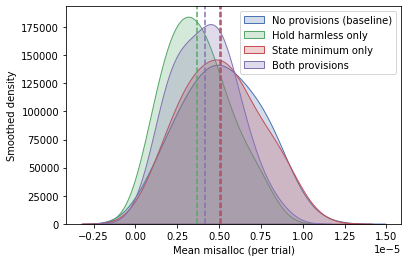

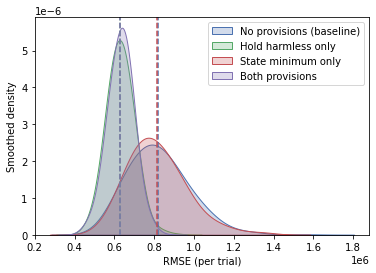

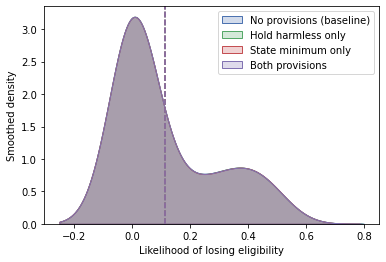

Plotting error_per_child


/home/rsteed/dp-acs/dp_policy/titlei/evaluation.py:265: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  joined = geo.join(
/home/rsteed/dp-acs/dp_policy/titlei/evaluation.py:265: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  joined = geo.join(
/home/rsteed/dp-acs/dp_policy/titlei/evaluation.py:265: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  joined = geo.join(
/home/rsteed/dp-acs/dp_policy/titlei/evaluation.py:265: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  joined = geo.join(


All but 4876 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.445795649116857
All but 1197 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.335549546535052
All but 4782 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 5.071131050232743
All but 1249 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.643939872344716


In [8]:
experiment = Experiment.get_experiment("hold_harmless", **experiment_kwargs)
experiment.plot()

### Post-processing

/home/rsteed/dp-acs
[INFO] Successfully imputed 2937 new indices
-- WARNING: dropping some balances from total budget --
Puerto Rico 412450771.2306171
County balances 723748.7996060263
Part D Subpart 2 104168000.98352575
Using given baseline...
Comparing at eps= 0.1
13190000

# None
True budget: 11661575735226.518
DP est budget: 11661575735226.523
Avg prop. districts erroneously ineligible: 2433.081
# est
# rows: 13190000
Max error: 122889197.16521525
-- RMSE --
RMSE: 828717.1424257592
Avg. RMSE 815292.0521261405
RMSE in exp. error: 60100.07570028349
-- Losses --
Avg. (per trial) # of districts losing $$: 6302.805
Avg. total losses: 1058190847.8711585
Std. total losses: 31845028.451168723
Total exp losses: 107961143.18492502
Average exp loss 20878.19438888513
Total 5% quantile losses: 4228022142.210911
Avg. 5% quantile loss: -339137.0933031933
-- Misalloc --
Avg. total abs misalloc: 2116381695.7423165
Total exp abs misalloc: 215922286.3698497
# dpest
# rows: 13190000
Max error: 1210777

/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


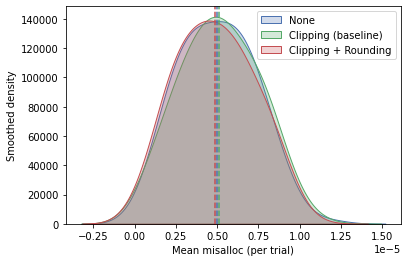

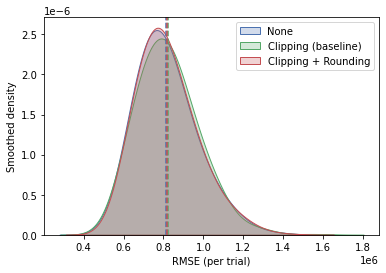

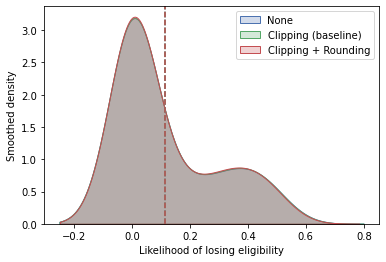

Plotting error_per_child


/home/rsteed/dp-acs/dp_policy/titlei/evaluation.py:265: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  joined = geo.join(
/home/rsteed/dp-acs/dp_policy/titlei/evaluation.py:265: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  joined = geo.join(
/home/rsteed/dp-acs/dp_policy/titlei/evaluation.py:265: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  joined = geo.join(


All but 4846 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.479180619361243
All but 4876 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.445795649116857
All but 4892 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.441330417731699


In [5]:
experiment = Experiment.get_experiment("post_processing", **experiment_kwargs)
experiment.plot()

### Moving average

/home/rsteed/dp-acs
[INFO] Successfully imputed 2937 new indices
-- WARNING: dropping some balances from total budget --
Puerto Rico 412450771.2306171
County balances 723748.7996060263
Part D Subpart 2 104168000.98352575
Using given baseline...
Comparing at eps= 0.1
13190000

# Lag 0
True budget: 11661575735226.54
DP est budget: 11661575735226.521
Avg prop. districts erroneously ineligible: 2398.474
# est
# rows: 13190000
Max error: 151783167.54649478
-- RMSE --
RMSE: 836235.5783195198
Avg. RMSE 822486.2372210638
RMSE in exp. error: 68754.5169008172
-- Losses --
Avg. (per trial) # of districts losing $$: 6296.473
Avg. total losses: 1060421256.1049548
Std. total losses: 31529577.155638758
Total exp losses: 113583042.44385897
Average exp loss 22567.661920099137
Total 5% quantile losses: 4228908071.126723
Avg. 5% quantile loss: -339317.0240814188
-- Misalloc --
Avg. total abs misalloc: 2120842512.2099097
Total exp abs misalloc: 227166084.88771778
# dpest
# rows: 13190000
Max error: 152144

/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


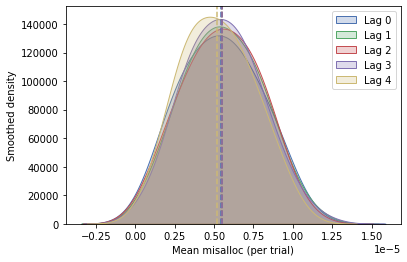

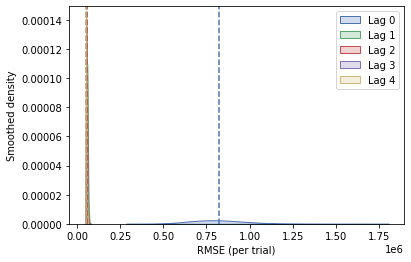

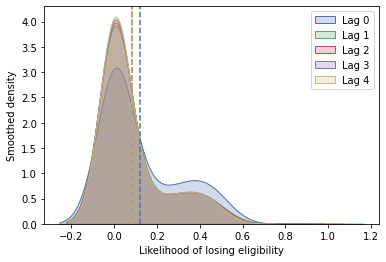

Plotting error_per_child


/home/rsteed/dp-acs/dp_policy/titlei/evaluation.py:265: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  joined = geo.join(
/home/rsteed/dp-acs/dp_policy/titlei/evaluation.py:265: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  joined = geo.join(
/home/rsteed/dp-acs/dp_policy/titlei/evaluation.py:265: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  joined = geo.join(
/home/rsteed/dp-acs/dp_policy/titlei/evaluation.py:265: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  joined = geo.join(
/home/rsteed/dp-acs/dp_policy/titlei/evaluation.py:265: FutureWarning: merging between different levels is deprecated and wi

All but 4628 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.445795649116857
All but 2939 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 3.5417134859222488
All but 2590 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 3.2729425360086024
All but 4653 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 3.5510822675496874
All but 7704 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 3.0846028954150975


In [6]:
experiment = Experiment.get_experiment("moving_average", **experiment_kwargs)
experiment.plot()

### Alternative thresholding

/home/rsteed/dp-acs
[INFO] Successfully imputed 2937 new indices
-- WARNING: dropping some balances from total budget --
Puerto Rico 412450771.2306171
County balances 723748.7996060263
Part D Subpart 2 104168000.98352575
Using given baseline...
Comparing at eps= 0.1
13190000

# None
True budget: 11661575735226.518
DP est budget: 11661575735226.52
Avg prop. districts erroneously ineligible: 0.0
# est
# rows: 13190000
Max error: 129673766.37931299
-- RMSE --
RMSE: 830153.2993262162
Avg. RMSE 816830.6200294315
RMSE in exp. error: 244880.56612480842
-- Losses --
Avg. (per trial) # of districts losing $$: 5323.065
Avg. total losses: 1057834622.2705191
Std. total losses: 30661661.568215266
Total exp losses: 367005483.36323524
Average exp loss 82920.35322260173
Total 5% quantile losses: 3921491631.720135
Avg. 5% quantile loss: -322783.0794073698
-- Misalloc --
Avg. total abs misalloc: 2115669244.541038
Total exp abs misalloc: 734010966.7264702
# dpest
# rows: 13190000
Max error: 130158581.792

/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/pandas/core/array

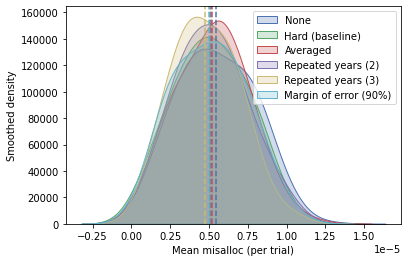

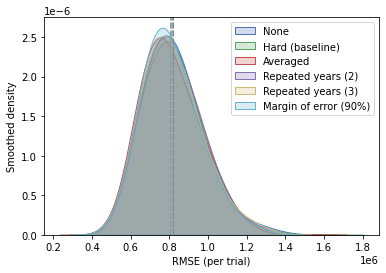

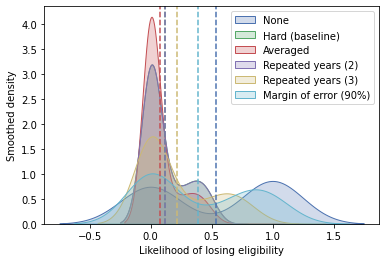

Plotting error_per_child


/home/rsteed/dp-acs/dp_policy/titlei/evaluation.py:265: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  joined = geo.join(
/home/rsteed/dp-acs/dp_policy/titlei/evaluation.py:265: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  joined = geo.join(
/home/rsteed/dp-acs/dp_policy/titlei/evaluation.py:265: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  joined = geo.join(
/home/rsteed/dp-acs/dp_policy/titlei/evaluation.py:265: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  joined = geo.join(
/home/rsteed/dp-acs/dp_policy/titlei/evaluation.py:265: FutureWarning: merging between different levels is deprecated and wi

All but 1932 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.230177290055269
All but 4876 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.445795649116857
All but 8079 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.316067540415581
All but 4920 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.490327698595198
All but 5077 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.469121834489666
All but 3201 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.3081303243192535


In [7]:
experiment = Experiment.get_experiment("thresholds", **experiment_kwargs)
experiment.plot()

### Epsilon Sensitivity

/home/rsteed/dp-acs
[INFO] Successfully imputed 2937 new indices
-- WARNING: dropping some balances from total budget --
Puerto Rico 412450771.2306171
County balances 723748.7996060263
Part D Subpart 2 104168000.98352575
Using given baseline...
[WARN] Epsilon is none - only use this if there is only one eps value in the df.
13190000

# 0.001
True budget: 11661575735226.518
DP est budget: 11661575735226.543
Avg prop. districts erroneously ineligible: 5721.446
# est
# rows: 13190000
Max error: 139072184.83536857
-- RMSE --
RMSE: 838271.1479192198
Avg. RMSE 824055.4655441602
RMSE in exp. error: 54708.6953282431
-- Losses --
Avg. (per trial) # of districts losing $$: 6305.323
Avg. total losses: 1060791577.2623
Std. total losses: 31366008.811736863
Total exp losses: 105344700.12856969
Average exp loss 20387.981445436362
Total 5% quantile losses: 4235069348.2119746
Avg. 5% quantile loss: -339702.3620928832
-- Misalloc --
Avg. total abs misalloc: 2121583154.5245996
Total exp abs misalloc: 210

/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/pandas/core/array

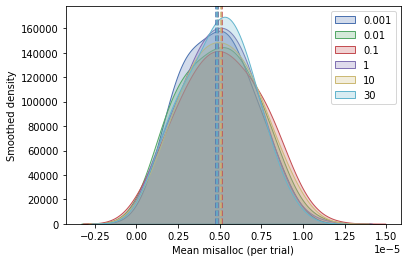

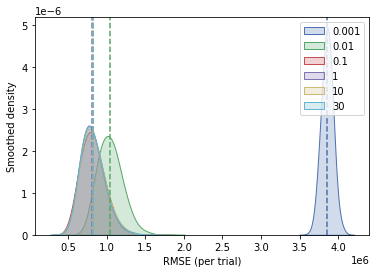

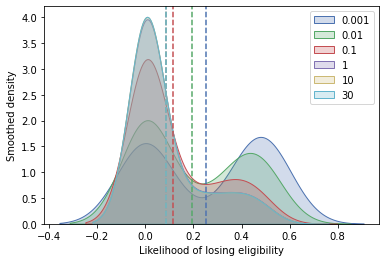

Plotting error_per_child


/home/rsteed/dp-acs/dp_policy/titlei/evaluation.py:265: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  joined = geo.join(
/home/rsteed/dp-acs/dp_policy/titlei/evaluation.py:265: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  joined = geo.join(
/home/rsteed/dp-acs/dp_policy/titlei/evaluation.py:265: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  joined = geo.join(
/home/rsteed/dp-acs/dp_policy/titlei/evaluation.py:265: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  joined = geo.join(
/home/rsteed/dp-acs/dp_policy/titlei/evaluation.py:265: FutureWarning: merging between different levels is deprecated and wi

All but 4888 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.504062637901318
All but 4882 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.470929850024668
All but 4876 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.445795649116857
All but 4889 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.477590831920147
All but 4915 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.487953583339739
All but 4924 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.483007391042044


In [8]:
experiment = Experiment.get_experiment("epsilon", **experiment_kwargs)
experiment.plot()

### Budget increases

/home/rsteed/dp-acs
[INFO] Successfully imputed 2937 new indices
-- WARNING: dropping some balances from total budget --
Puerto Rico 412450771.2306171
County balances 723748.7996060263
Part D Subpart 2 104168000.98352575
Using given baseline...
Comparing at eps= 0.1
13190000

# Biden proposal ($2.0e+10)
True budget: 11661575735226.518
DP est budget: 26392660487364.074
Avg prop. districts erroneously ineligible: 2431.081
# est
# rows: 13190000
Max error: 634239475.1444138
-- RMSE --
RMSE: 7006617.652557893
Avg. RMSE 6992690.573434783
RMSE in exp. error: 6748621.220483945
-- Losses --
Avg. (per trial) # of districts losing $$: 1232.359
Avg. total losses: 70935450.46151763
Std. total losses: 4024017.148862245
Total exp losses: 0.0
Average exp loss nan
Total 5% quantile losses: 365330567.12559015
Avg. 5% quantile loss: -49209.39751152885
-- Misalloc --
Avg. total abs misalloc: 14872955653.060492
Total exp abs misalloc: 14731084752.137457
# dpest
# rows: 13190000
Max error: 630500453.656798

/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


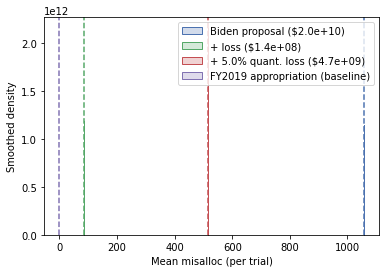

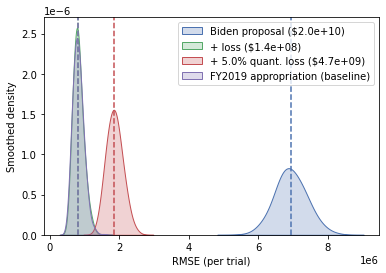

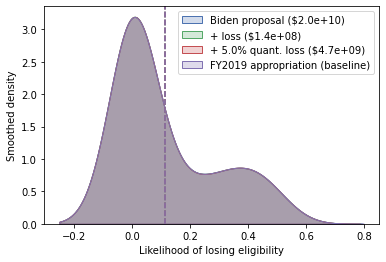

Plotting error_per_child


/home/rsteed/dp-acs/dp_policy/titlei/evaluation.py:265: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  joined = geo.join(
/home/rsteed/dp-acs/dp_policy/titlei/evaluation.py:265: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  joined = geo.join(
/home/rsteed/dp-acs/dp_policy/titlei/evaluation.py:265: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  joined = geo.join(
/home/rsteed/dp-acs/dp_policy/titlei/evaluation.py:265: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  joined = geo.join(


All but 216 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 5.83738893910143
All but 4593 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.446933453116911
All but 257 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.818899193645726
All but 4876 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.445795649116857


In [9]:
experiment = Experiment.get_experiment("budget", **experiment_kwargs)
experiment.plot()

### Sampling variance sensitivity

/home/rsteed/dp-acs
[INFO] Successfully imputed 2937 new indices
-- WARNING: dropping some balances from total budget --
Puerto Rico 412450771.2306171
County balances 723748.7996060263
Part D Subpart 2 104168000.98352575
Using given baseline...
Comparing at eps= 0.1
13190000

# Gaussian (0.5)
True budget: 11661575735226.518
DP est budget: 11661575735226.527
Avg prop. districts erroneously ineligible: 1754.718
# est
# rows: 13190000
Max error: 68171363.97382161
-- RMSE --
RMSE: 418522.3284026681
Avg. RMSE 411816.46692210605
RMSE in exp. error: 28152.55030548239
-- Losses --
Avg. (per trial) # of districts losing $$: 6285.166
Avg. total losses: 532889968.5996185
Std. total losses: 15092268.232257757
Total exp losses: 53090634.07408291
Average exp loss 8516.303188014583
Total 5% quantile losses: 2161867412.289659
Avg. 5% quantile loss: -173407.1879593855
-- Misalloc --
Avg. total abs misalloc: 1065779937.1992366
Total exp abs misalloc: 106181268.1481655
# dpest
# rows: 13190000
Max error:

/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/rsteed/dp-acs/venv/lib/python3.9/site-packages/pandas/core/array

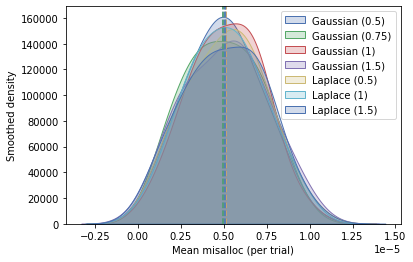

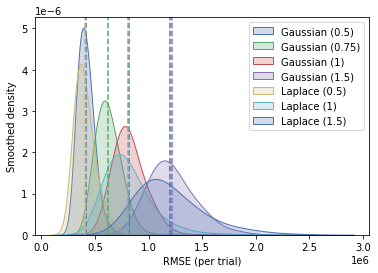

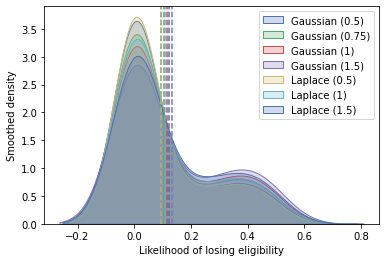

Plotting error_per_child


/home/rsteed/dp-acs/dp_policy/titlei/evaluation.py:265: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  joined = geo.join(
/home/rsteed/dp-acs/dp_policy/titlei/evaluation.py:265: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  joined = geo.join(
/home/rsteed/dp-acs/dp_policy/titlei/evaluation.py:265: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  joined = geo.join(
/home/rsteed/dp-acs/dp_policy/titlei/evaluation.py:265: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  joined = geo.join(
/home/rsteed/dp-acs/dp_policy/titlei/evaluation.py:265: FutureWarning: merging between different levels is deprecated and wi

All but 6499 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.026153442114566
All but 5493 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.2137342977930725
All but 4936 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.485819679186682
All but 3871 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.852386883230494
All but 6653 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.013733619409673
All but 5103 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.501875553823508
All but 4073 are significantly different from zero at 0.1
None of the 90.0% MOEs exceeds 4.941599828707744


In [4]:
experiment = Experiment.get_experiment("sampling", **experiment_kwargs)
experiment.plot()

## [DEPRECATED] Gaussian (Advanced Composition, Approx. DP)

Add Gaussian noise ln(1/delta)/epsilon for better accuracy bound.

/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/diffprivlib/mechanisms/gaussian.py:161: RuntimeWarning: overflow encountered in exp
  return phi(np.sqrt(epsilon * val)) - np.exp(epsilon) * phi(- np.sqrt(epsilon * (val + 2))) - delta
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/diffprivlib/mechanisms/gaussian.py:161: RuntimeWarning: invalid value encountered in double_scalars
  return phi(np.sqrt(epsilon * val)) - np.exp(epsilon) * phi(- np.sqrt(epsilon * (val + 2))) - delta
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/diffprivlib/mechanisms/gaussian.py:164: RuntimeWarning: overflow encountered in exp
  return phi(- np.sqrt(epsilon * val)) - np.exp(epsilon) * phi(- np.sqrt(epsilon * (val + 2))) - delta
/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/diffprivlib/mechanisms/gaussian.py:164: RuntimeWarning: invalid value encountered in double_scalars
  return phi(- np.sqrt(epsilon * val)) - np.exp(epsilon) * phi(- np.sqrt(epsilon * (val + 2))) - delta


(0.001, 0.027825594022071243, 0.774263682681127, 2.52, 21.54434690031882, 599.4842503189409, 16681.005372000593, 464158.8833612772, 12915496.650148828, 359381366.3804626, 10000000000.0)
## dp
## basic grants ##
RMSE at eps=2.52: 21399.19796113853
RMSE prop eps=2.52: 0.004691125745169814
Total misalloc at eps=2.52: 1857499037.3476112
Total true alloc: 398753867558.1087
## concentration grants ##
RMSE at eps=2.52: 100671.3283797714
RMSE prop eps=2.52: 0.006430091290918551
Total misalloc at eps=2.52: 1869504093.5586305
Total true alloc: 294198199337.48425
## targeted grants ##
RMSE at eps=2.52: 56692.94880990919
RMSE prop eps=2.52: 0.004404833980625078
Total misalloc at eps=2.52: 2903765215.9326797
Total true alloc: 667259095030.0739
## total grants ##
RMSE at eps=2.52: 15266.238953544133
RMSE prop eps=2.52: 0.00492429570329448
Total misalloc at eps=2.52: 787839065.3432262
Total true alloc: 159990202216.03195


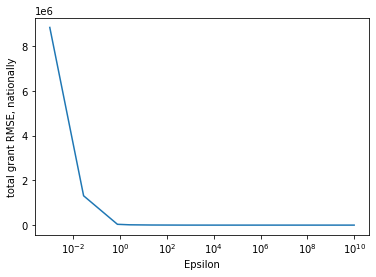

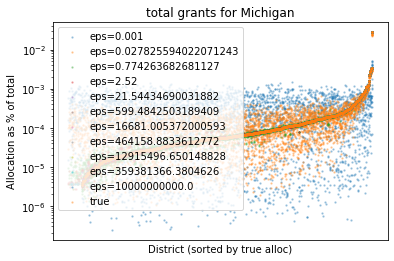

/Users/steed/dp-acs/dp_policy/api.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alloc['err_prop'] = (


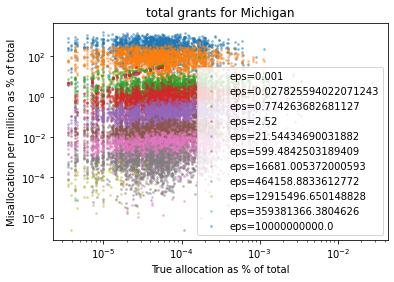

## dpest
## basic grants ##
RMSE at eps=2.52: 2730892.7708471036
RMSE prop eps=2.52: 0.1605220789051688
Total misalloc at eps=2.52: 64100091418.47471
Total true alloc: 398753867558.1087
## concentration grants ##
RMSE at eps=2.52: 3115379.4280794035
RMSE prop eps=2.52: 0.2559038715010952
Total misalloc at eps=2.52: 75780426908.8416
Total true alloc: 294198199337.48425
## targeted grants ##
RMSE at eps=2.52: 7905797.344754197
RMSE prop eps=2.52: 0.20086854941523397
Total misalloc at eps=2.52: 136090233079.47676
Total true alloc: 667259095030.0739
## total grants ##
RMSE at eps=2.52: 1550976.8201538778
RMSE prop eps=2.52: 0.20096552176913365
Total misalloc at eps=2.52: 32152514466.29373
Total true alloc: 159990202216.03195


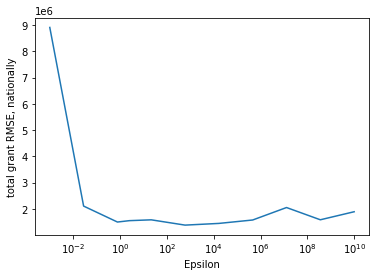

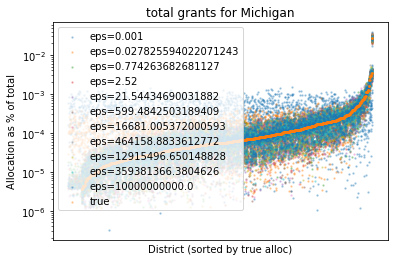

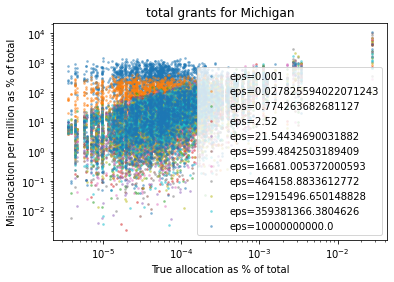

In [18]:
from dp_policy.titlei.mechanisms import Gaussian

# with delta = 0
results = test_params(
    saipe,
    Gaussian, 
    delta=list(np.linspace(1e-8, 1e-5, endpoint=False, num=10)),
    auth=False
)

Comparing dp


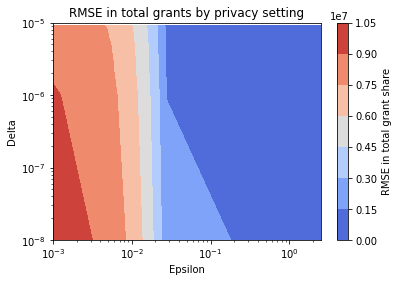

Comparing dpest


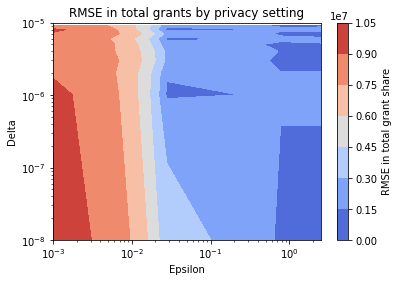

In [25]:
for prefix in ('dp', 'dpest'):
    print("Comparing", prefix)

    grant_type = 'total'

    eps = list(results.index.get_level_values("epsilon").unique())

    delts = list(results.index.get_level_values("delta").unique())
    mse = np.zeros((len(eps), len(delts)))
    for params, alloc in results.groupby(["epsilon", "delta"]):
        
        e, d = params
        error = alloc[f"true_grant_{grant_type}"] \
            - alloc[f"{prefix}_grant_{grant_type}"]
        mse[eps.index(e), delts.index(d)] = np.sqrt(sum(error**2)/alloc.shape[0])
        
    plt.contourf(eps, delts, mse.transpose(), cmap="coolwarm")
    ax = plt.gca()
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_yticks([1e-8, 1e-7, 1e-6, 1e-5])
    # ax.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
    plt.xlim(None, 2.5)
    plt.xlabel("Epsilon")
    plt.ylabel("Delta")
    plt.title("RMSE in total grants by privacy setting")
    plt.colorbar(label="RMSE in total grant share")
    plt.show()